In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs 

### plotting 
from matplotlib import pyplot as plt
import seaborn as sns

### dask 
from dask.diagnostics import ProgressBar

In [3]:
import dask

### paths 

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### load local libraries 

In [5]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [6]:
sys.path.append('../../') 

In [7]:
from ICU_Water_Watch import geo, C3S, domains, plot, verification

### import libraries for validation

In [8]:
import climpred
from climpred import HindcastEnsemble
import xskillscore as xs

### parameters for papermill 

In [10]:
quantile = 'tercile'
varname = 'TPRATE'
period = 'monthly'

## read the quantile probabilities from the GCMs 

In [11]:
GCMs = ['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP', 'JMA']

In [12]:
dset_mme = []

for GCM in GCMs: 
    
    dpath_gcm = pathlib.Path(f"/media/nicolasf/END19101/ICU/data/CDS/{GCM}/{quantile}_probs/{varname}") 
    
    lfiles = list(dpath_gcm.glob(f"*{period}_{quantile}*.netcdf"))
    
    lfiles.sort()
    
    print(f"reading {len(lfiles)} files for GCM {GCM}") 
    
    dset_gcm = xr.open_mfdataset(lfiles, parallel=True, engine='netcdf4')
    
    dset_gcm = dset_gcm.expand_dims({'GCM':[GCM]})
    
    dset_mme.append(dset_gcm)

reading 288 files for GCM ECMWF
reading 287 files for GCM UKMO
reading 288 files for GCM METEO_FRANCE
reading 288 files for GCM DWD
reading 288 files for GCM CMCC
reading 288 files for GCM NCEP
reading 288 files for GCM JMA


In [13]:
dset_mme = xr.concat(dset_mme, dim='GCM')

In [14]:
dset_mme

,Array,Chunk
Bytes,2.21 GiB,1.12 MiB
Shape,"(7, 288, 3, 5, 81, 121)","(1, 1, 3, 5, 81, 121)"
Count,13246 Tasks,2016 Chunks
Type,float64,numpy.ndarray


### calculates the MME probability as the average of the individual GCMs' probabilities across the GCM dimension 

In [15]:
mme_ave = dset_mme.mean('GCM').expand_dims({'GCM':['MME']})

### compute 

In [16]:
with ProgressBar(): 
    
    mme_ave = mme_ave.compute()

[########################################] | 100% Completed | 10.2s


### should sum to 100 over the quantile dimension 

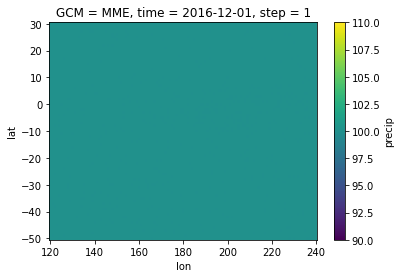

In [17]:
mme_ave.sum(dim=quantile).isel(time=-1, step=0).squeeze()['precip'].plot()

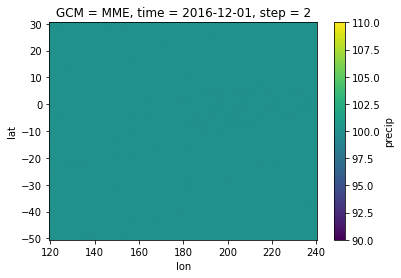

In [18]:
mme_ave.sum(dim=quantile).isel(time=-1, step=1).squeeze()['precip'].plot()

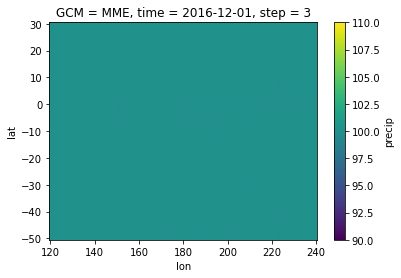

In [19]:
mme_ave.sum(dim=quantile).isel(time=-1, step=2).squeeze()['precip'].plot()

In [20]:
dset_mme  = mme_ave.merge(dset_mme)

In [21]:
dset_mme['GCM']

<xarray.DataArray 'GCM' (GCM: 8)>
array(['CMCC', 'DWD', 'ECMWF', 'JMA', 'METEO_FRANCE', 'MME', 'NCEP', 'UKMO'],
      dtype='<U12')
Coordinates:
  * GCM      (GCM) <U12 'CMCC' 'DWD' 'ECMWF' 'JMA' ... 'MME' 'NCEP' 'UKMO'

### saves to disk 

In [22]:
!ls ../../outputs/

C3S				ERA5_Suva_NadiAirport.csv  ICU_forecast_table
C3S_MME_quartile_probabilities	ERA_quartile_categories    ICU_validation
C3S_MME_tercile_probabilities	ERA_tercile_categories


In [23]:
opath_mme_probabilities = CWD.parents[1].joinpath(f"outputs/C3S_MME_{quantile}_probabilities")

In [24]:
if not(opath_mme_probabilities.exists()): 
    opath_mme_probabilities.mkdir(parents=True)

In [25]:
opath_mme_probabilities

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/C3S_MME_tercile_probabilities')

In [26]:
dset_mme.chunks

Frozen({'GCM': (1, 1, 1, 1, 2, 1, 1), 'time': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'tercile': (3,), 'step': (5,), 'lat': (81,), 'lon': (121,)})

In [27]:
dset_mme = dset_mme.chunk({'time':-1, 'GCM':-1, quantile:1, 'step':1, 'lat':10, 'lon':10})

In [28]:
opath_mme_probabilities

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/C3S_MME_tercile_probabilities')

In [29]:
dset_mme.to_zarr(opath_mme_probabilities.joinpath(f"C3S_MME_{period}_{quantile}_probabilities.zarr"))

In [30]:
dset_mme

,Array,Chunk
Bytes,2.52 GiB,1.76 MiB
Shape,"(8, 288, 3, 5, 81, 121)","(8, 288, 1, 1, 10, 10)"
Count,44633 Tasks,1755 Chunks
Type,float64,numpy.ndarray
